## Experiment:  FASHIONMNIST - Learn Variance

Training params:
    - Network: VAEVariance
    - Batch size: 64
    - Image type: Full image
    - Background subtraction: False
    - Background subtraction value: 0.0
    - Image-size: 28 x 28
    - Optimizer: Adam
    - Initial LR: 0.001

In [1]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.mnist import MNISTDataModule
from src.data.mnist import ConstantDataset
from src.data.fashionmnist import FashionMNISTDataModule
from src.data.bg_aug_mnist import BgAugFashionMNISTDataModule
import torch
from src.models.vae.basic_vae_variance import BasicVAEVariance
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [3]:
print(os.cpu_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed_everything(42)

20
cuda:0


42

In [4]:
mnist = MNISTDataModule()
fashion = FashionMNISTDataModule()
constant_black = ConstantDataset()
aug_fashion = BgAugFashionMNISTDataModule(single_image=True)

mnist.prepare_data()
mnist.setup()

fashion.prepare_data()
fashion.setup()

aug_fashion.prepare_data()
aug_fashion.setup()

# experiment_name = 'BasicVAEVariance_FASHIONMNIST_Full_Image'
# experiment_name = 'BasicVAEVariance_LogPDF_FASHIONMNIST_Full_Image'
experiment_name = 'BasicVAEVariance_LogPDF_BgAUG_FASHIONMNIST_Full_Image'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=5,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=20, gpus=1, logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)


EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [5]:
model = BasicVAEVariance(use_custom_loss = False, bg_aug_train=True)
trainer.fit(model, aug_fashion)

Set SLURM handle signals.

  | Name     | Type       | Params
----------------------------------------
0 | fc1      | Linear     | 314 K 
1 | fc_mu_z  | Linear     | 32 K  
2 | fc_var_z | Sequential | 32 K  
3 | fc2      | Linear     | 32 K  
4 | fc_mu_x  | Linear     | 314 K 
5 | fc_var_x | Sequential | 314 K 
6 | relu     | ReLU       | 0     


Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

1

In [6]:
from pathlib import Path

path = Path('models/' + experiment_name)
path.mkdir(parents=True, exist_ok=True)


trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [7]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_VAE_full_img = BasicVAEVariance(use_custom_loss = False, bg_aug_train=True).load_from_checkpoint(checkpoint_path=model_path).cuda()
eval_VAE_full_img.eval()
mnist_test = mnist.test_dataloader()
fashion_test = fashion.test_dataloader()

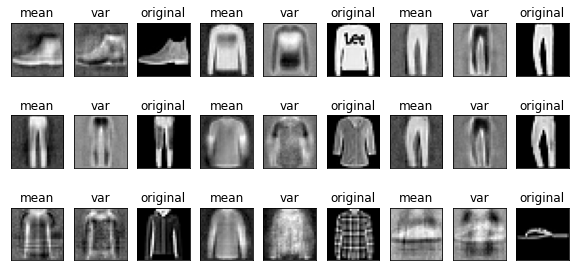

In [8]:
from src.utils.vae import generate_images

generate_images(eval_VAE_full_img, fashion_test)

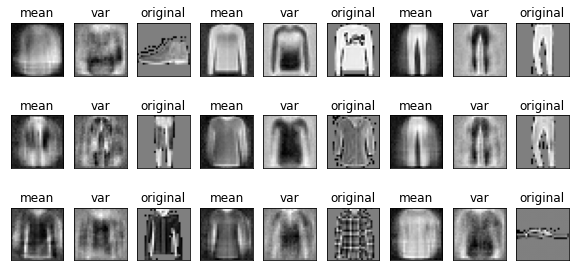

In [9]:
from src.utils.vae import generate_images

generate_images(eval_VAE_full_img, fashion_test, random_bg=True)

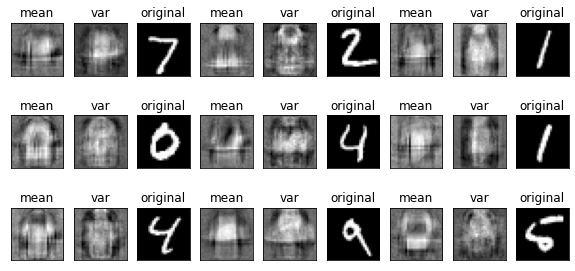

In [10]:
from src.utils.vae import generate_images
# latent dim = 40
generate_images(eval_VAE_full_img, mnist_test)

In [11]:
from src.utils.vae import reconstructed_probability
i = 0
in_dist_recon = []
for img in iter(fashion_test):
    img = img[0][0]
    recon_prob = reconstructed_probability(img, eval_VAE_full_img)
    in_dist_recon.append(recon_prob)
#     print(recon_prob)
#     plt.imshow(img[0, :, :].detach().cpu().numpy(), cmap="gray")
#     plt.show()
#     i += 1

In [15]:
from src.utils.vae import reconstructed_probability
i = 0
ood_recon = []
for img in iter(fashion_test):
    img = img[0][0]
    recon_prob = reconstructed_probability(img, eval_VAE_full_img, random_bg=True)
    ood_recon.append(recon_prob)
#     print(recon_prob)
#     plt.imshow(img[0, :, :].detach().cpu().numpy(), cmap="gray")
#     plt.show()
#     i += 1

In [12]:
from src.utils.vae import reconstructed_probability
i = 0
ood_recon = []
for img in iter(mnist_test):
    img = img[0][0]
    recon_prob = reconstructed_probability(img, eval_VAE_full_img)
    ood_recon.append(recon_prob)
#     print(recon_prob)
#     plt.imshow(img[0, :, :].detach().cpu().numpy(), cmap="gray")
#     plt.show()
#     i += 1

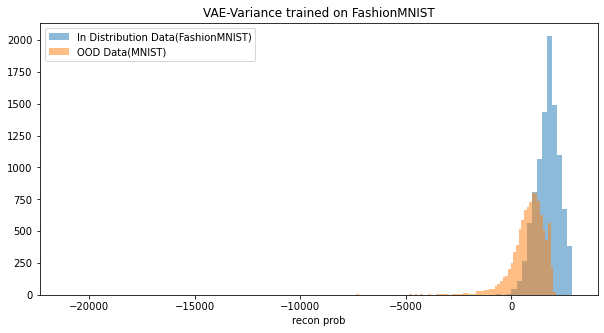

In [13]:
plt.figure(figsize=(10,5))
plt.hist(np.array(in_dist_recon), 100, alpha=0.5, label='In Distribution Data(FashionMNIST)')
plt.hist(np.array(ood_recon), 150, alpha=0.5, label='OOD Data(MNIST)')
plt.legend(loc='upper left')
plt.xlabel('recon prob')
plt.title('VAE-Variance trained on FashionMNIST')
plt.show()

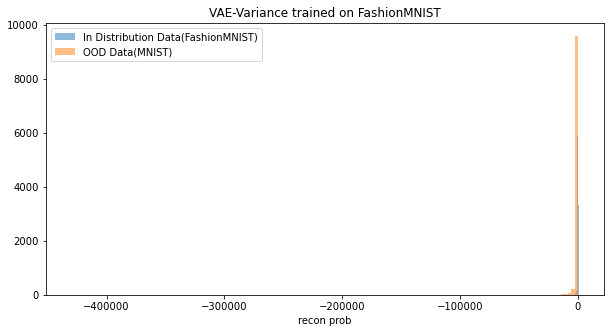

In [13]:
plt.figure(figsize=(10,5))
plt.hist(np.array(in_dist_recon), 100, alpha=0.5, label='In Distribution Data(FashionMNIST)')
plt.hist(np.array(ood_recon), 150, alpha=0.5, label='OOD Data(MNIST)')
plt.legend(loc='upper left')
plt.xlabel('recon prob')
plt.title('VAE-Variance trained on FashionMNIST')
plt.show()

 ROC AUC=0.84765


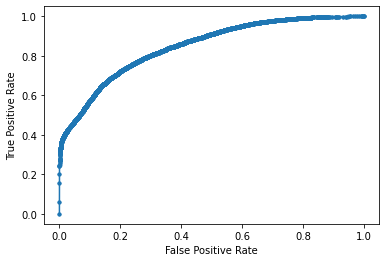

In [14]:
from src.utils.ood_test import plot_roc_auc
targets = np.concatenate((np.ones(len(in_dist_recon)), np.zeros(len(ood_recon))))
results = np.concatenate((in_dist_recon, ood_recon))
plot_roc_auc(targets, results)

 ROC AUC=0.94270


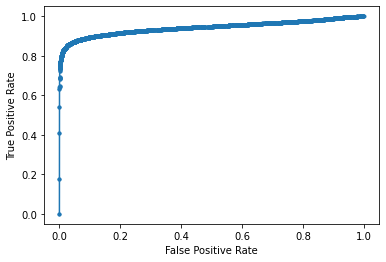

In [14]:
from src.utils.ood_test import plot_roc_auc
targets = np.concatenate((np.ones(len(in_dist_recon)), np.zeros(len(ood_recon))))
results = np.concatenate((in_dist_recon, ood_recon))
plot_roc_auc(targets, results)

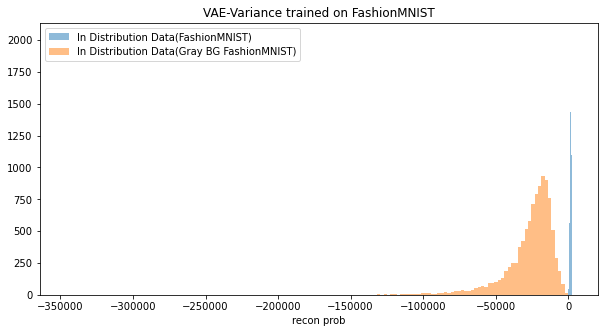

In [16]:
plt.figure(figsize=(10,5))
plt.hist(np.array(in_dist_recon), 100, alpha=0.5, label='In Distribution Data(FashionMNIST)')
plt.hist(np.array(ood_recon), 150, alpha=0.5, label='In Distribution Data(Gray BG FashionMNIST)')
plt.legend(loc='upper left')
plt.xlabel('recon prob')
plt.title('VAE-Variance trained on FashionMNIST')
plt.show()

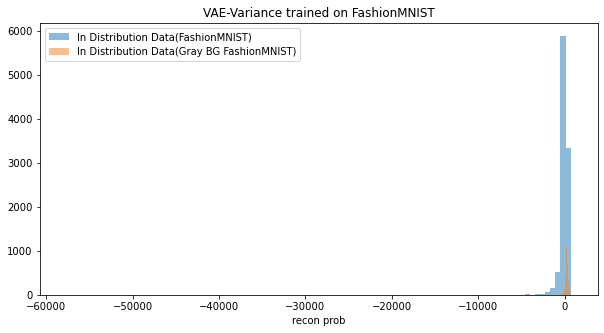

In [16]:
plt.figure(figsize=(10,5))
plt.hist(np.array(in_dist_recon), 100, alpha=0.5, label='In Distribution Data(FashionMNIST)')
plt.hist(np.array(ood_recon), 150, alpha=0.5, label='In Distribution Data(Gray BG FashionMNIST)')
plt.legend(loc='upper left')
plt.xlabel('recon prob')
plt.title('VAE-Variance trained on FashionMNIST')
plt.show()

 ROC AUC=0.99995


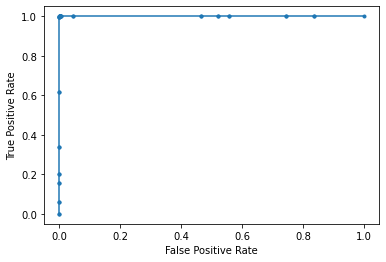

In [17]:
from src.utils.ood_test import plot_roc_auc
targets = np.concatenate((np.ones(len(in_dist_recon)), np.zeros(len(ood_recon))))
results = np.concatenate((in_dist_recon, ood_recon))
plot_roc_auc(targets, results)

 ROC AUC=0.17780


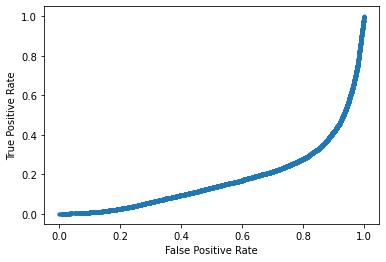

In [17]:
from src.utils.ood_test import plot_roc_auc
targets = np.concatenate((np.ones(len(in_dist_recon)), np.zeros(len(ood_recon))))
results = np.concatenate((in_dist_recon, ood_recon))
plot_roc_auc(targets, results)